In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.functional as F

from tqdm.auto import tqdm
from PIL import Image
from torch import nn
from torch.ao import quantization as q
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights

## Датасет

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ILSVRC/imagenet-1k", split="validation", streaming=True)

In [23]:
for sample in dataset:
    print(sample)
    break

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=408x500 at 0x7F2415538FA0>, 'label': 91}


In [34]:
label_mapping = dataset.features["label"].int2str

coucal


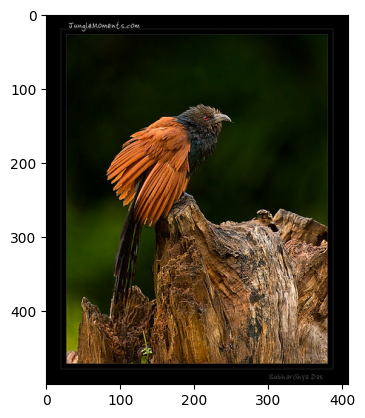

In [35]:
imagenet_sample = next(iter(dataset))
input_image = imagenet_sample["image"].convert("RGB")

print(label_mapping(imagenet_sample["label"]))
plt.imshow(np.array(input_image));

In [36]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 224, 224])

## DenseNet121

In [42]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [43]:
with torch.no_grad():
    probs = torch.nn.functional.softmax(model(input_batch)[0], dim=0)
probs.shape

torch.Size([1000])

In [51]:
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(label_mapping(int(top5_catid[i])), top5_prob[i].item())

coucal 0.9992121458053589
kite 0.0003053034597542137
vulture 0.00012781469558831304
jacamar 0.00011707199882948771
bulbul 7.718153938185424e-05


## DenseNet121 модель с квантизацией

In [52]:
class QuantizedDenseNet121(nn.Module):
    def __init__(self):
        super().__init__()
        self.dn = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        self.quant = q.QuantStub()
        self.dequant = q.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.dn(x)
        return self.dequant(x)


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
print("Supported engines:", torch.backends.quantized.supported_engines)
q_engine = torch.backends.quantized.supported_engines[0]

torch.backends.quantized.engine = q_engine
torch.backends.quantized.engine

Supported engines: ['qnnpack', 'none', 'onednn', 'x86', 'fbgemm']


'qnnpack'

In [ ]:
model = QuantizedDenseNet121().to(device)
model.eval()
model.qconfig = q.get_default_qconfig(q_engine) # HistogramObserver для входов и MinMaxObserver для весов
model = q.prepare(model, inplace=False)

In [57]:
calibration_data = dataset.take(500)

In [60]:
model.eval()
with torch.no_grad():
    for sample in tqdm(calibration_data, desc="Calibration"):
        image = preprocess(sample["image"].convert("RGB")).unsqueeze(0).to(device)
        model(image)

Calibration: 0it [00:00, ?it/s]

Calibration: 500it [01:20,  6.19it/s]
Calibration: 500it [01:20,  6.19it/s]


In [61]:
model.cpu()
model_quant = q.convert(model, inplace=False)

In [63]:
with torch.no_grad():
    probs = torch.nn.functional.softmax(model_quant(input_batch)[0], dim=0)
probs.shape

torch.Size([1000])

In [65]:
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(label_mapping(int(top5_catid[i])), top5_prob[i].item())

coucal 0.9894754886627197
vulture 0.004502308089286089
kite 0.0027976350393146276
bulbul 0.001080194255337119
macaw 0.00041707404307089746
